In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np
import xarray as xr
import skimage
import matplotlib.pyplot as plt
nax = np.newaxis

sys.path.append('..')
%aimport mre_pinn

Using backend: pytorch



# BIOQIC Phantom ground truth

In [3]:
%autoreload

data, test_data = mre_pinn.data.load_bioqic_dataset('../data/BIOQIC', 'phantom', downsample=False)
data

Loading ../data/BIOQIC/phantom_unwrapped_dejittered.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
    magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
    phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64
Loading ../data/BIOQIC/phantom_elastogram.npy
Loading ../data/BIOQIC/phantom_regions.npy
Multi frequency 3D
<xarray.Dataset>
Dimensions:         (frequency: 8, component: 3, t: 8, z: 25, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * component       (component) <U1 'z' 'y' 'x'
  * t               (t) int64 0 1 2 3 4 5 6 7
  * z               (z) float64 0.0 0.0015 0.003 0.0045 ... 0.033 0.0345 0.036
  * x               (x) float64 0.0 0.0015 0.003 0.0045 ... 0.1875 0.189 0.19

[Errno 2] No such file or directory: '../data/BIOQIC/phantom_elastogram.npy'
[Errno 2] No such file or directory: '../data/BIOQIC/phantom_regions.npy'


<xarray.Dataset>
Dimensions:         (frequency: 8, component: 3, t: 8, z: 25, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * component       (component) <U1 'z' 'y' 'x'
  * t               (t) int64 0 1 2 3 4 5 6 7
  * z               (z) float64 0.0 0.0015 0.003 0.0045 ... 0.033 0.0345 0.036
  * x               (x) float64 0.0 0.0015 0.003 0.0045 ... 0.1875 0.189 0.1905
  * y               (y) float64 0.0 0.0015 0.003 0.0045 ... 0.1155 0.117 0.1185
Data variables:
    a               (frequency, t, x, y, z, component) uint16 0 0 0 ... 33 78 13
    u               (frequency, t, x, y, z, component) float64 -0.6366 ... -0...
    mu              (x, y, z) float64 -0.0 0.0 0.0 -0.0 ... 0.0 0.0 0.0 -0.0
    spatial_region  (x, y, z) float64 -0.0 0.0 0.0 -0.0 ... 0.0 0.0 0.0 -0.0
    Lu              (frequency, t, x, y, z, component) float64 -3.368e+06 ......
    Mu              (frequency, t, x, y, z) float64 9.081 -13.87 ... -516.2

<IPython.core.display.Javascript object>


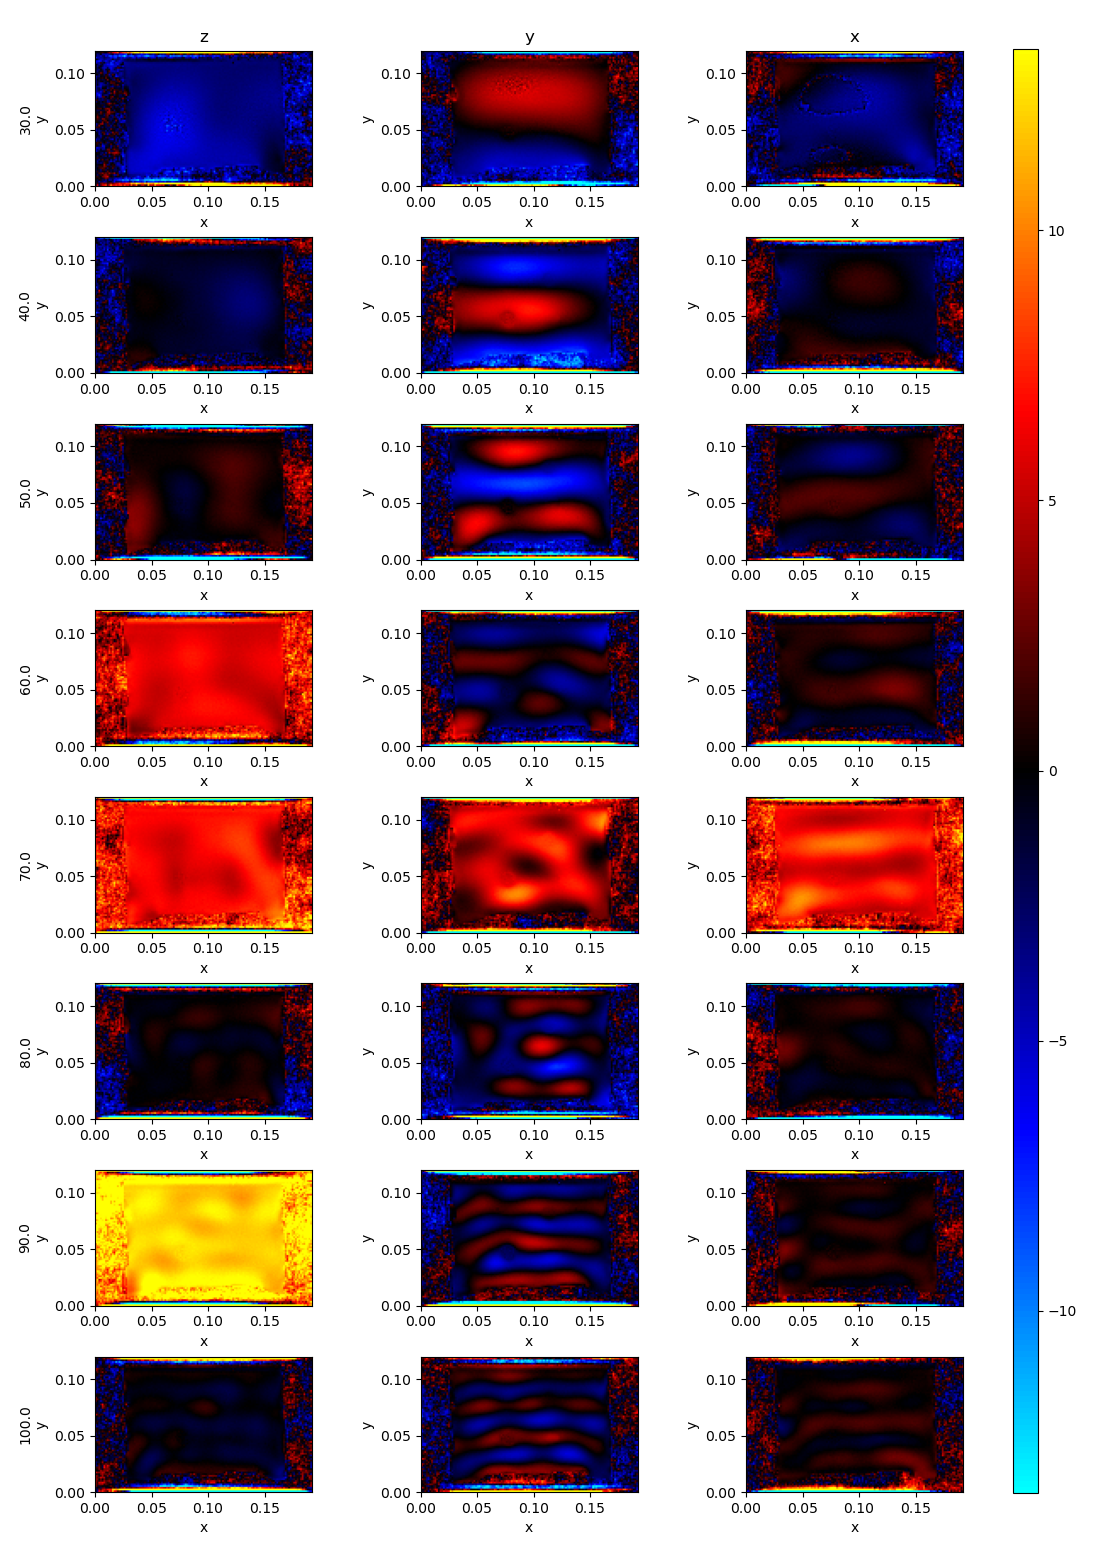

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [4]:
%autoreload

anat_kws = mre_pinn.visual.get_color_kws(data.a)
wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu, pct=50)
elast_kws = mre_pinn.visual.get_color_kws(data.Mu, pct=50)
mask_kws = mre_pinn.visual.get_color_kws(data.spatial_region)

mre_pinn.visual.XArrayViewer(data.u, col='component', row='frequency', **wave_kws)

In [12]:
data.field.spatial_resolution

array([0.0015, 0.0015, 0.0015])

<IPython.core.display.Javascript object>


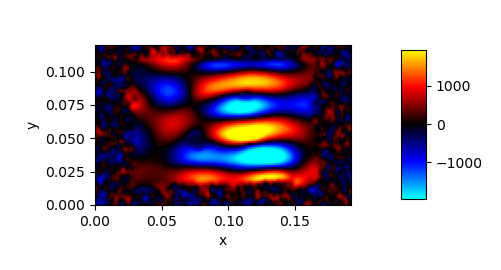

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [55]:
%autoreload
proc_data = mre_pinn.data.preprocess_bioqic_phantom_data(data, sigma=0.65, threshold=100, order=1)

wave_kws = mre_pinn.visual.get_color_kws(proc_data.u)
mre_pinn.visual.XArrayViewer(proc_data.u, **wave_kws)

<IPython.core.display.Javascript object>


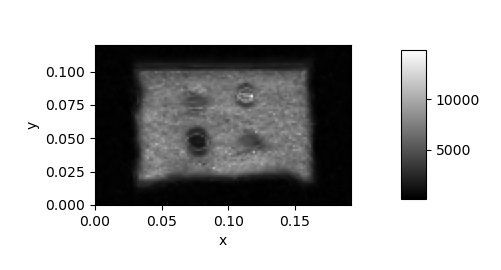

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


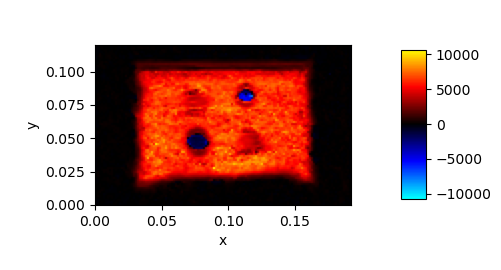

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [71]:
%autoreload

u = proc_data.u
Lu = mre_pinn.discrete.laplacian(u)
Mu = mre_pinn.discrete.helmholtz_inversion(u, Lu, polar=True)

mre_pinn.visual.XArrayViewer(Mu.mean('frequency'), cmap='gray', polar=True)
mre_pinn.visual.XArrayViewer(Mu.mean('frequency'), **mre_pinn.visual.get_color_kws(Mu))